_Lambda School Data Science, Unit 2_

---

👇 **Do not change the code in this cell.** If you're working in Google Colab, you can run this cell to install `category_encoders` and `pdpbox`.

In [1]:
%%capture
import sys

if 'google.colab' in sys.modules:
    !pip install category_encoders
    !pip install pdpbox

# Sprint Challenge: Predict Chicago Food Inspections 🍕

In this challenge, you'll use data from the [Chicago Department of Public Health](https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_restaurants/svcs/food-protection-services.html) to build a model to predict whether a food establishment passed inspection or not.

The purpose of this model is to help inspectors use their time more efficiently by identifying establishments that will likely fail inspection. In other words, this model should be able to predict whether an establishment will fail inspection *before* the inspector arrives at the establishment. 

# Directions

This notebook contains 12 tasks, which cover the material we've learned in this sprint. Here's a summary:

- **Task 1:** Importing data.
- **Task 2:** Identifying data leakage.
- **Task 3:** Writing a wrangle function.
- **Task 4:** Splitting data into a feature matrix and target vector.
- **Task 5:** Splitting data into training and validation sets.
- **Task 6:** Establishing baseline accuracy.
- **Task 7:** Building model with bagging predictor.
- **Task 8:** Building model with boosting predictor.
- **Task 9 (`stretch goal`):** Plotting ROC curves.
- **Task 10:** Generating classification report.
- **Task 11:** Calculating permutation importances.
- **Task 12 (`stretch goal`):** Creating PDP interaction plot.

For each task you should do the following:

- Read the task instructions.
- Write your code in the cell below the task. Delete the `raise NotImplementedError` before your start.
- Run the testing cell below the task. If you get an error, read the error message and re-evaluate your code.

**You should limit your code to the following libraries:**

- `category_encoders`
- `numpy`
- `matplotlib`
- `pandas`
- `pdpbox`
- `sklearn`
- `xgboost`

**A word of warning:** The virtual machine that will check your answers is small. So, where applicable, don't use huge values for `n_estimators` (`>100`) or `n_jobs` (keep at `-1`). 

If you'd like to import all your libraries at the start of your notebook, you can do so in the code block below 👇

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# I. Wrangle Data

**Task 1:** Change the code below to import your dataset. Be sure to examine the columns carefully and determine if one of them should be set as the index.

In [3]:
'''T1. Import data file.'''
url = 'https://drive.google.com/uc?export=download&id=1aUnQ4AJK4UtW8JL9zPyYUMtkjIgQpqKT'
df = pd.read_csv(url,parse_dates=['Inspection Date'])
df.set_index('Inspection Date',inplace=True)
print(df.shape)
df

(51916, 17)


,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Type,Violations,Latitude,Longitude,Location,Fail,Serious Violations Found
Inspection Date,,,,,,,,,,,,,,,,,
2017-09-15,2088270,"TOM YUM RICE & NOODLE, INC.",TOM YUM CAFE,2354911.0,Restaurant,Risk 1 (High),608 W BARRY,CHICAGO,IL,60657.0,Canvass,3. POTENTIALLY HAZARDOUS FOOD MEETS TEMPERATUR...,41.938007,-87.644755,"{'longitude': '-87.6447545707008', 'latitude':...",1,2.0
2011-10-20,555268,FILLING STATION & CONVENIENCE STORE,FILLING STATION & CONVENIENCE STORE,1044901.0,Grocery Store,Risk 3 (Low),6646-6658 S WESTERN AVE,CHICAGO,IL,60636.0,Complaint Re-Inspection,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,41.772402,-87.683603,"{'longitude': '-87.68360273081268', 'latitude'...",0,0.0
2016-04-05,1751394,A P DELI,A P DELI,47405.0,Restaurant,Risk 1 (High),2025 E 75TH ST,CHICAGO,IL,60649.0,Canvass Re-Inspection,"35. WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTR...",41.758779,-87.575054,"{'longitude': '-87.57505446746121', 'latitude'...",0,0.0
2016-04-29,1763905,FRANK'S CHICAGO SHRIMP HOUSE,FRANK'S CHICAGO SHRIMP HOUSE,6414.0,Restaurant,Risk 2 (Medium),4459 S ARCHER AVE,CHICAGO,IL,60632.0,Canvass,38. VENTILATION: ROOMS AND EQUIPMENT VENTED AS...,41.812181,-87.707125,"{'longitude': '-87.70712481334274', 'latitude'...",0,0.0
2011-01-10,453326,MORRILL,MORRILL,24571.0,School,Risk 1 (High),6011 S Rockwell (2600W) AVE,CHICAGO,IL,60629.0,Canvass,"34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOO...",NaN,NaN,NaN,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-10-29,1370030,VANILLE PATTISSERIE,VANILLE PATTISSERIE,2129404.0,Grocery Store,Risk 2 (Medium),131 N CLINTON ST,CHICAGO,IL,60661.0,Canvass,NaN,41.884188,-87.641120,"{'longitude': '-87.64111966683218', 'latitude'...",0,NaN
2011-02-25,579387,CHICAGO STEAK HOUSE,CHICAGO STEAK HOUSE,2079910.0,Restaurant,Risk 2 (Medium),219 E 47TH ST,CHICAGO,IL,60653.0,License Re-Inspection,NaN,41.809214,-87.620308,"{'longitude': '-87.62030817634384', 'latitude'...",0,NaN
2018-05-14,2169678,JEWEL FOOD STORE #3043,JEWEL FOOD STORE #3043,1144384.0,Grocery Store,Risk 1 (High),443 E 34TH ST,CHICAGO,IL,60616.0,Canvass Re-Inspection,33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSI...,41.833045,-87.614611,"{'longitude': '-87.61461136443168', 'latitude'...",0,0.0


**Task 1 Test**

In [4]:
'''T1 Test'''
assert isinstance(df, pd.DataFrame), 'Have you created a DataFrame named `df`?'
assert len(df) == 51916

**Task 2:** Given that this model is supposed to generate predictions *before* an inspection is conducted, identify the numerical feature that is an example of **data leakage.** Assign the column name to the variable `'leaky_col'`.

**Remember:** Leakage is when your feature matrix includes columns that will not be available to your model at the time it make predictions.



In [5]:
'''T2. Identify data leakage column.'''
leaky_col = 'Serious Violations Found'

**Task 2 Test**

In [6]:
'''T2 Test'''
# This is a hidden test. 
# You'll see the result when you submit to Canvas.
assert isinstance(leaky_col, str), '`leaky_col` should be type `str`.'

**Task 3:** Add to the `wrangle` function below so that it does the following:

- Removes the "leaky" column.
- Removes high-cardinality categorical columns (more than `500` categories).
- Removes categorical columns that have only one category.
- Removes numerical columns that are unique identifiers for each observation, not features that would affect the target.

In [7]:
'''T3. Write wrangle function.'''
def objectify(string):
  # converts float into string
  i = str(string)
  return i.split(".")[0]

def wrangle(df):
  df.drop(leaky_col,axis=1,inplace=True)
  #drops leaky column

  df['License #'] = df['License #'].apply(objectify)
  df['Zip'] = df['Zip'].apply(objectify)
  df['Inspection ID'] = df['Inspection ID'].apply(str)
  # makes zip code and license number into categorical values, because they shouldnt be floats. This would make it so that license number (high cardinality) would be removed by the next part of this function
  # and that zip code (low cardinality) would be put into the model to see if it has an effect on our model.
  # shows inspection id as high cardinality object, removing it in the next part of this function

  cardinality = df.select_dtypes('object').nunique()
  categorical_col = cardinality[(cardinality<=500) & (cardinality>1)].index.tolist()
  numerical_col = df.select_dtypes('number').columns.tolist()
  features = categorical_col + numerical_col
  #removes high cardinality features, and categorical features with only one category


  return df[features]

df = wrangle(df)

**Task 3 Test**

In [8]:
'''T3 Test'''
assert df.select_dtypes('object').nunique().max() < 500, 'Have you dropped the high-cardinality columns?'
assert df.select_dtypes('object').nunique().min() > 1, 'Have you dropped the column with only one category?'

# II. Split Data

**Task 4:** Split the DataFrame `df` into the feature matrix `X` and the target vector `y`. Your target is `'Fail'`.

In [9]:
'''T4. Split feature matrix and target vector.'''
target = 'Fail'
y = df[target]
xfeatures = df.drop(target,axis=1).columns
X = df[xfeatures]

**Task 4 Test**

In [10]:
'''T4 Test'''
assert y.shape == (51916,), '`y` either has the wrong number of rows, or is two-dimentional.'
assert len(X) == 51916, '`X` has the wrong number of rows.'

**Task 5:** Split your dataset into training and validation sets.

- Your training set (`X_train`, `y_train`) should contain inspections conducted before 2017.
- Your validation set (`X_val`, `y_val`) should contain inspections conducted during or after 2017.

In [11]:
'''T5. Split dataset into training and validation sets.'''
cutoff = '2017-01-01'
mask = X.index < cutoff
X_train, y_train = X.loc[mask], y.loc[mask]
X_val, y_val = X.loc[~mask], y.loc[~mask]
X_val

,Facility Type,Risk,City,Zip,Inspection Type,Latitude,Longitude
Inspection Date,,,,,,,
2017-09-15,Restaurant,Risk 1 (High),CHICAGO,60657,Canvass,41.938007,-87.644755
2017-01-12,Restaurant,Risk 2 (Medium),CHICAGO,60606,Canvass,41.878531,-87.639427
2017-02-10,School,Risk 1 (High),CHICAGO,60638,Canvass Re-Inspection,41.799052,-87.758965
2017-08-01,Liquor,Risk 3 (Low),CHICAGO,60610,License,41.902312,-87.628497
2018-10-31,Restaurant,Risk 1 (High),CHICAGO,60614,Complaint,41.932864,-87.647246
...,...,...,...,...,...,...,...
2017-08-25,Restaurant,Risk 1 (High),CHICAGO,60640,Canvass,41.973167,-87.657438
2017-07-17,Restaurant,Risk 2 (Medium),CHICAGO,60610,License,41.908246,-87.634474
2018-01-09,Restaurant,Risk 1 (High),CHICAGO,60623,License Re-Inspection,41.844550,-87.710615


**Task 5 Testing**

In [12]:
'''T5 Test'''
assert len(X_train) == len(y_train) == 41827, 'Your training set has the wrong number of observations.'
assert len(X_val) == len(y_val) == 10089, 'Your validation set has the wrong number of observations.'

# III. Establish Baseline

**Task 6:** Establish the baseline accuracy score for this classification problem using your training set. Save the score to the variable `baseline_acc`.

In [13]:
'''T6. Establish baseline accuracy.'''
baseline_acc = y_train.value_counts(normalize=True)[0]
print('Baseline accuracy:', baseline_acc)

Baseline accuracy: 0.7506634470557295


**Task 6 Testing**

In [14]:
'''T6 Test'''
assert isinstance(baseline_acc, float), '`baseline_acc` should be type float. Have you defined the variable?'
assert 0.0 <= baseline_acc <= 1.0

# IV. Build Model

In this section, you want to answer the question: Which ensemble method performs better with this data — bagging or boosting?

**Task 7:** Build a model that includes a bagging predictor (`RandomForest`). Your predictor should be part of a pipeline named `model_bag` that includes any transformers that you think are necessary.

In [15]:
'''T7. Build model with bagging predictor.'''
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import make_pipeline

model_bag = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='most_frequent'),
    RandomForestClassifier(random_state=42)
)
model_bag.fit(X_train, y_train);

**Tast 7 Testing**

In [16]:
'''T7 Testing'''
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
assert isinstance(model_bag, Pipeline), '`model_bag` is the wrong data type. Have you assigned your pipeline to the correct variable name?'
assert isinstance(model_bag[-1], RandomForestClassifier), 'Your predictor should be a `RandomForestClassifier`.'
assert hasattr(model_bag[-1], 'feature_importances_'), 'Have you trained your model?'

**Task 8:** Build a model that includes a boosting predictor (`GradientBoostingClassifier` from `sklearn` or `XGBClassifier` from `xgboost`). Your predictor should be part of a pipeline named `model_boost` that includes any transformers that you think are necessary. 

In [17]:
'''T8. Build model with boosting predictor.'''
model_boost = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='most_frequent'),
    GradientBoostingClassifier(random_state=42)
)
model_boost.fit(X_train, y_train);

**Task 8 Testing**

In [18]:
'''T8 Testing'''
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
assert isinstance(model_boost, Pipeline), '`model_boost` is the wrong data type. Have you assigned your pipeline to the correct variable name?'
assert any([isinstance(model_boost[-1], XGBClassifier),
            isinstance(model_boost[-1], GradientBoostingClassifier)]), 'Your predictor should be `XGBClassifier` or `GradientBoostingClassifier`.'

# V. Check Metrics

Here are the accuracy scores for your two models. Did you beat the baseline? Which of your two models appears to perform better on your validation set?

In [19]:
print('Bagging Model')
print('Training accuracy:', model_bag.score(X_train, y_train))
print('Validation accuracy:', model_bag.score(X_val, y_val))
print()
print('Boosting Model')
print('Training accuracy:', model_boost.score(X_train, y_train))
print('Validation accuracy:', model_boost.score(X_val, y_val))

Bagging Model
Training accuracy: 0.9077390202500777
Validation accuracy: 0.68004757656854

Boosting Model
Training accuracy: 0.7562101035216487
Validation accuracy: 0.703439389434037


**Task 9 (`stretch_goal`):** Plot the ROC-curve for both of your models (you can plot them one-at-a-time, side-by-side, or in the same plot).

In [20]:
bag_y_pred_proba = model_bag.predict_proba(X_val)[:,1]
boost_y_pred_proba = model_boost.predict_proba(X_val)[:,1]

Text(0, 0.5, 'True Positive Rate')

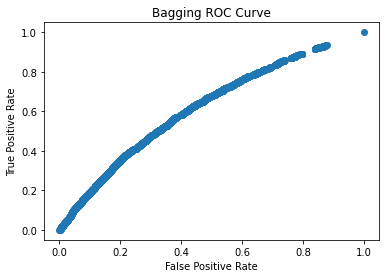

In [21]:
'''T9. Plot ROC-curve.'''
from sklearn.metrics import roc_curve

fpr_bag, tpr_bag, bag_thresh = roc_curve(y_val,bag_y_pred_proba)
fpr_boost, tpr_boost, boost_thresh = roc_curve(y_val,boost_y_pred_proba)

plt.scatter(fpr_bag,tpr_bag)
plt.title('Bagging ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

Text(0, 0.5, 'True Positive Rate')

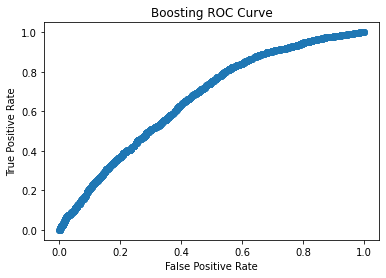

In [22]:
plt.scatter(fpr_boost,tpr_boost)
plt.title('Boosting ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

**Task 10:** Choose one of your models based on your validation accuracy score or your ROC curves. Then create a classification report for that model using your validation data. Save the text of the report to the variable name `model_cr`. 

In [23]:
'''T10. Generate classification report for one model.'''
from sklearn.metrics import classification_report
model_cr = classification_report(y_val, model_boost.predict(X_val),
                                 target_names = ['did not fail' , 'failed inspection'])
print(model_cr)

                   precision    recall  f1-score   support

     did not fail       0.71      0.99      0.82      7092
failed inspection       0.52      0.03      0.05      2997

         accuracy                           0.70     10089
        macro avg       0.61      0.51      0.44     10089
     weighted avg       0.65      0.70      0.59     10089



**Task 10 Testing**

In [24]:
assert isinstance(model_cr, str), '`model_cr` should be type `str`.'
assert all(term in model_cr for term in ['precision', 'recall', 'f1-score', 'support']), 'Is this a classification report?'

**Task 11:** Using your best model, create a DataFrame `permutation_importances` with the model's permutation importances based on your validation data.

- The index of the DataFrame should be your feature names.
- The first column should be the mean importance.
- The second column should be the importance standard deviation.

In [25]:
'''T11. Create DataFrame of permutation importances.'''
from sklearn.inspection import permutation_importance
model_boost_perm_imp = permutation_importance(model_boost,X_val,y_val,n_jobs=-1,random_state=42)
boost_perm_imp = {'mean_importance' : model_boost_perm_imp['importances_mean'],
                  'std_importance': model_boost_perm_imp['importances_std']}
permutation_importances = pd.DataFrame(boost_perm_imp,index=X_val.columns)
permutation_importances

,mean_importance,std_importance
Facility Type,-7.334721e-04,0.000231
Risk,-5.947071e-04,0.000208
City,-1.784121e-04,0.000040
Zip,1.189414e-04,0.000537
Inspection Type,2.973536e-03,0.000822
Latitude,1.466944e-03,0.001358
Longitude,-4.440892e-17,0.000198


**Task 11 Testing**

In [26]:
'''Task 11 Test'''
assert isinstance(permutation_importances, pd.DataFrame), '`permutation_importances` should be type `DataFrame`.'
assert permutation_importances.shape == (7,2)

**Task 12 (`stretch goal`):** Using your best model, create a PDP interaction plot to examine how `'Latitude'` and `'Longitude'` inform predictions. Remember to user your validation data.

**Note:** Because of the way that `pdp_interact` works, it will throw an error if there are `NaN` values in your validation set. To avoid this problem, be sure to set `dataset` to `X_val.dropna()`.

In [28]:
'''T12. Create PDP interaction plot for "Latitude" and "Longitude".'''
from pdpbox.pdp import pdp_interact, pdp_interact_plot

features = ['Longitude', 'Latitude']

interact = pdp_interact(
    model = model_boost,
    dataset = X_val,
    model_features = X_val.columns,
    features = features
)
pdp_interact_plot(interact,plot_type='grid',feature_names=features);

ValueError: No objects to concatenate

What do you think? Is there a relationship between location and failing a food saftey inspection?